## Testings of SARIMAX model on hourly water consumption in Stuttgart
Landenwasserversorgung \
Weather data is from the station Stuttgart-Schnarrenberg

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.imputation.mice import MICEData
import matplotlib.pyplot as plt
import pmdarima as pmd
import h5py
import json
import warnings
from utils.sarima_forecast import train_and_forecast_sarima
from utils.fourier import fourier_series
import missingno as msno
import seaborn as sns

warnings.filterwarnings("ignore")

### 1.) Load Data

#### 1.1.) Read in water demand data

In [2]:
# Explore the structure of an HDF5 file
def explore_h5_structure(h5_file):
    for key in h5_file.keys():
        print(f"Group/Dataset: {key}")
        if isinstance(h5_file[key], h5py.Group):
            explore_h5_structure(h5_file[key])  # Recursively explore groups
        elif isinstance(h5_file[key], h5py.Dataset):
            print(f"Dataset shape: {h5_file[key].shape}, dtype: {h5_file[key].dtype}")

In [3]:
# Open the file
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    explore_h5_structure(system_demand)

Group/Dataset: system_demand
Group/Dataset: n_nodal_datapoints_available
Dataset shape: (247463,), dtype: float64
Group/Dataset: nodal_demand_sum
Dataset shape: (247463,), dtype: float64
Group/Dataset: time
Dataset shape: (7, 247463), dtype: int64


In [4]:
with h5py.File("../data/water_demand/system_demand.h5", "r") as system_demand:
    # Access a specific group
    group = system_demand["system_demand"]
    # Load the dataset into memory
    n_nodal_datapoints_available = group["n_nodal_datapoints_available"][:]
    nodal_demand = group["nodal_demand_sum"][:]
    system_time = group["time"][:]

In [5]:
# Build pandas df with datetime, nodal_demand_sum, n_nodal_datapoints_available
system_time_transposed = np.transpose(
    system_time
)  # transpose system time in long format
# create dataframe
df = pd.DataFrame(
    system_time_transposed,
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"],
)
df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour", "minute"]])
df["nodal_demand"] = nodal_demand
df["n_nodal_datapoints_available"] = n_nodal_datapoints_available
df.set_index("datetime", inplace=True)
df_hourly = df.resample(
    "h"
).median()  # Use sum for total demand per hour.resample('h').mean() #resample to hourly mean demand in Liter/s
df_hourly = df_hourly.drop(
    columns=["year", "month", "day", "hour", "minute", "second", "milisecond"]
)
df_hourly["date"] = df_hourly.index
df_hourly.head(5)

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2016-12-30 23:00:00,3117.642772,29.0,2016-12-30 23:00:00
2016-12-31 00:00:00,2476.503474,29.0,2016-12-31 00:00:00
2016-12-31 01:00:00,2336.120475,29.0,2016-12-31 01:00:00
2016-12-31 02:00:00,1882.216795,29.0,2016-12-31 02:00:00
2016-12-31 03:00:00,1821.650324,29.0,2016-12-31 03:00:00


##### 1.1.1.) Deal with missing data


In [6]:
# Only seven missing values, impute via mean of nearest neighbors
df_hourly[df_hourly["nodal_demand"].isna()]

,nodal_demand,n_nodal_datapoints_available,date
datetime,,,
2017-03-26 02:00:00,NaN,NaN,2017-03-26 02:00:00
2018-03-25 02:00:00,NaN,NaN,2018-03-25 02:00:00
2019-03-31 02:00:00,NaN,NaN,2019-03-31 02:00:00
2020-03-29 02:00:00,NaN,NaN,2020-03-29 02:00:00
2021-03-28 02:00:00,NaN,NaN,2021-03-28 02:00:00
2022-03-27 02:00:00,NaN,NaN,2022-03-27 02:00:00
2023-03-26 02:00:00,NaN,NaN,2023-03-26 02:00:00


In [7]:
# Fill missing values with the previous value
df_hourly = df_hourly.fillna(method="ffill")

#### 1.2.) Read in weather and holiday data
Weather data from the DWD stations Stuttgart-Schnarrenberg and Stuttgart-Echterdingen

In [16]:
# Load the Raw temperature data
temperature_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature_echterdingen = pd.read_csv(
    "../data/weather_climate/Temperaturdaten_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"TT_TU": "temperature"})

temperature = pd.merge(
    temperature_schnarrenberg,
    temperature_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [14]:
sun_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sun_echterdingen = pd.read_csv(
    "../data/weather_climate/Sonnenschein_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"SD_SO": "sunshine_duration"})

sunshine = pd.merge(
    sun_schnarrenberg,
    sun_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [24]:
precipitation_schnarrenberg = pd.read_csv(
    "../data/weather_climate/Niederschlag_Schnarrenberg_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})

precipitation_echterdingen = pd.read_csv(
    "../data/weather_climate/Niederschlag_Echterdingen_stuendlich.csv",
    index_col="MESS_DATUM",
    delimiter=";",
    parse_dates=["MESS_DATUM"],
).rename(columns={"  R1": "precipitation"})


precipitation = pd.merge(
    precipitation_schnarrenberg,
    precipitation_echterdingen,
    left_index=True,
    right_index=True,
    suffixes=("_Schnar", "_Echt"),
)

In [32]:
weather = pd.merge(
    temperature, sunshine, left_index=True, right_index=True, how="outer"
).merge(precipitation, left_index=True, right_index=True, how="outer")

weather.index = pd.to_datetime(weather.index, format="%Y%m%d%H")
weather = weather.rename_axis("datetime")
weather.replace(-999, np.nan, inplace=True)  # Replace missing values with NaN
weather = weather[
    [
        "temperature_Schnar",
        "temperature_Echt",
        "sunshine_duration_Schnar",
        "sunshine_duration_Echt",
        "precipitation_Schnar",
        "precipitation_Echt",
    ]
]
weather.describe()

,temperature_Schnar,temperature_Echt,sunshine_duration_Schnar,sunshine_duration_Echt,precipitation_Schnar,precipitation_Echt
count,314660.000000,312896.000000,280643.000000,280643.000000,222082.000000,222012.000000
mean,10.827399,9.943893,16.402312,16.402312,0.073916,0.077717
std,7.999841,8.113877,23.782343,23.782343,0.492626,0.503326
min,-16.200000,-18.400000,0.000000,0.000000,0.000000,0.000000
25%,4.800000,3.800000,0.000000,0.000000,0.000000,0.000000
50%,10.700000,9.800000,0.000000,0.000000,0.000000,0.000000
75%,16.600000,15.700000,36.000000,36.000000,0.000000,0.000000
max,37.900000,37.300000,60.000000,60.000000,52.900000,48.900000


##### 1.2.1.) Deal with missing data
Probably due to maintaince issues a "Missing at Random" (MAR) mechansim is given for the weather data, for both weather stations. Multiple Imputation (MI) is considered to impute missing data.

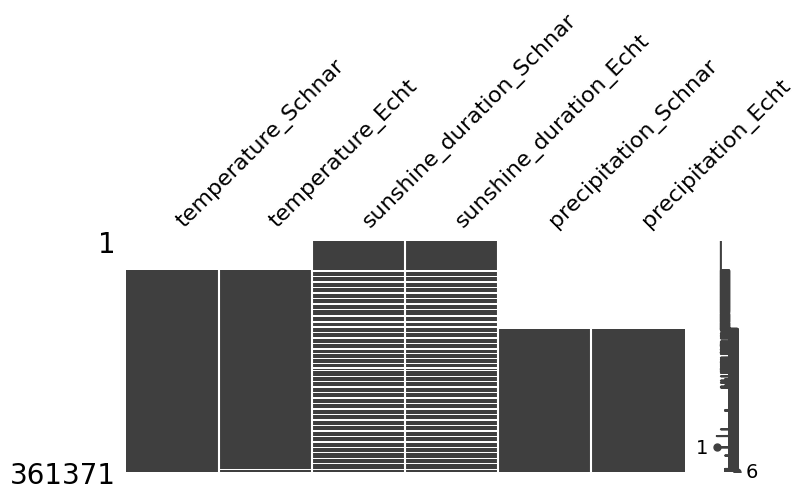

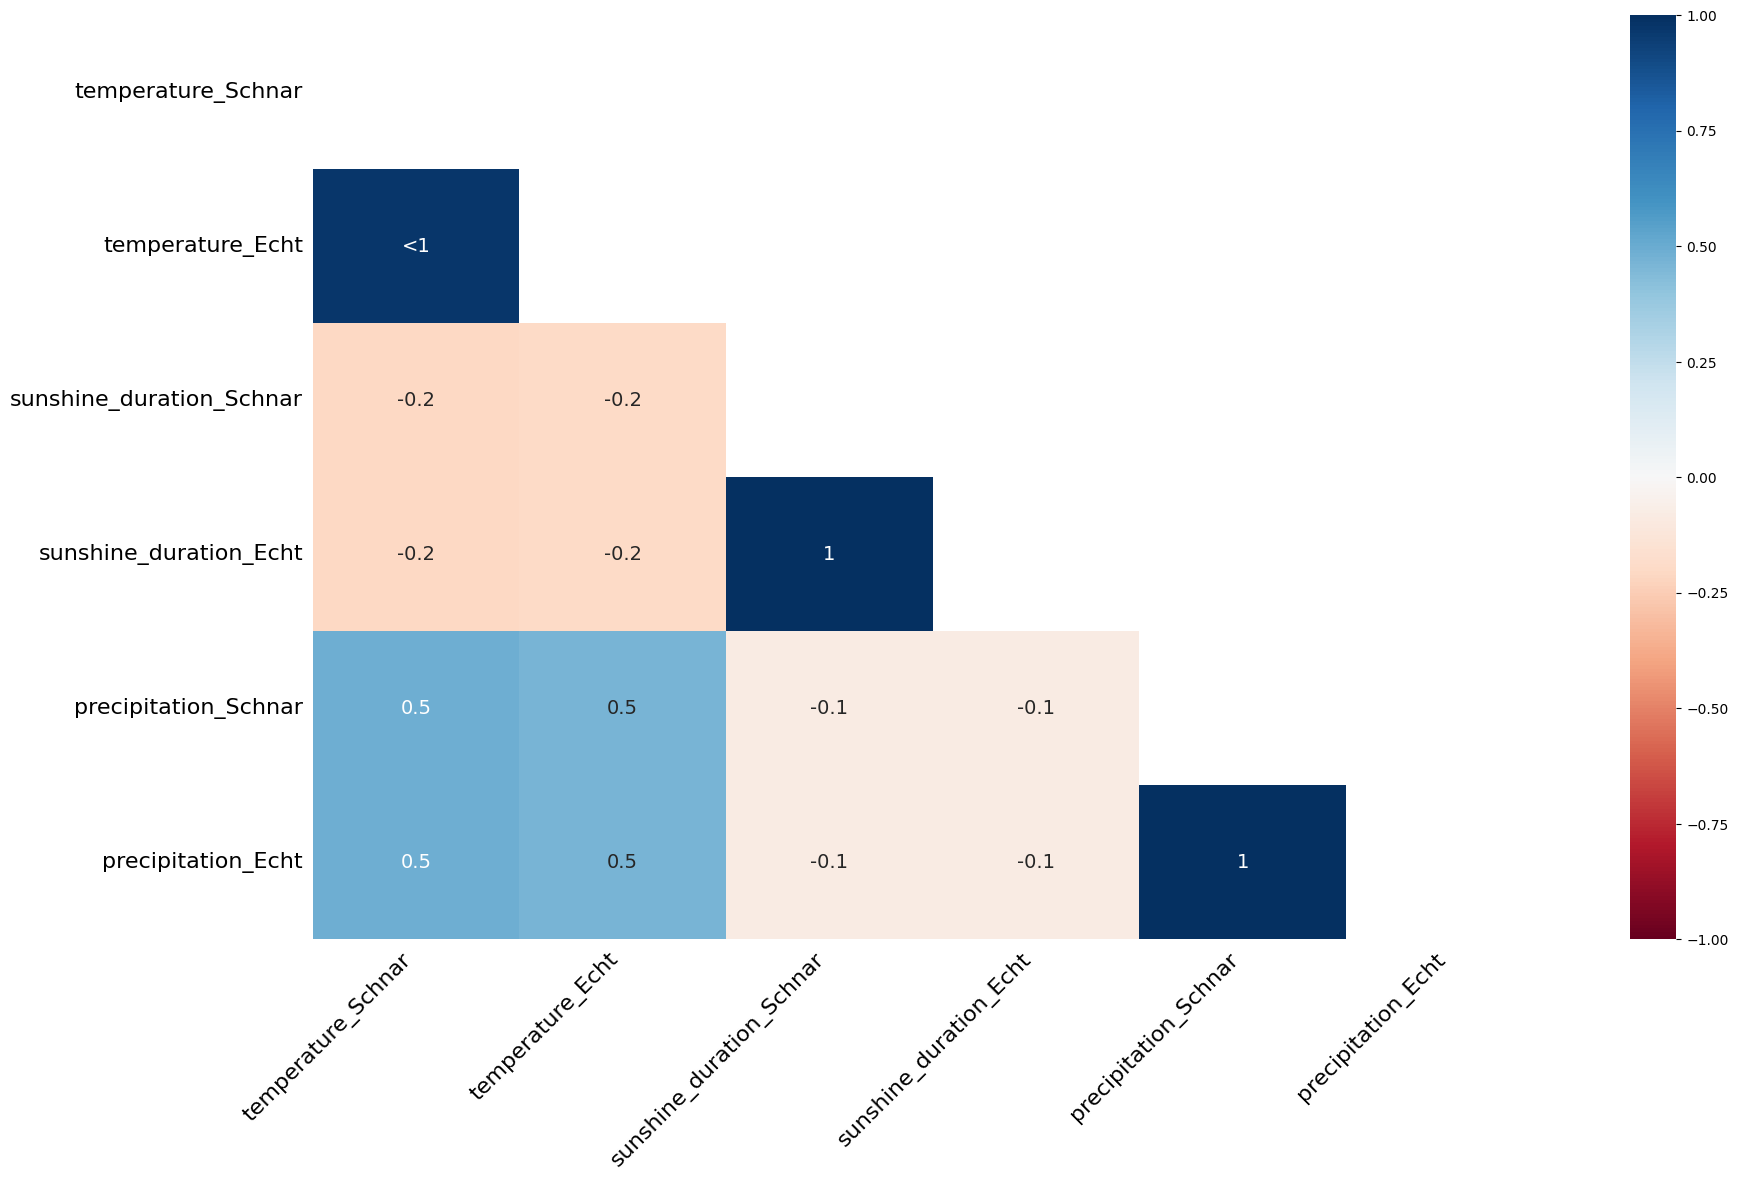

In [33]:
# Optional: Visualize missingness
msno.matrix(weather, figsize=(8, 3))
msno.heatmap(weather)
plt.show()

In [34]:
## Conduct multiple imputation using MICE

# Store original index
original_index = weather.index

# Initialize MICEData object
mice_data = MICEData(weather)

# Impute missing values
mice_data.update_all()

# Check imputed dataset
weather_imputed = mice_data.data
weather_imputed.index = original_index  # Reassign the original index
weather_imputed.head()

,temperature_Schnar,temperature_Echt,sunshine_duration_Schnar,sunshine_duration_Echt,precipitation_Schnar,precipitation_Echt
datetime,,,,,,
1981-01-01 03:00:00,10.3,9.7,0.0,0.0,0.3,0.0
1981-01-01 04:00:00,10.8,11.0,0.0,0.0,0.2,0.7
1981-01-01 05:00:00,10.1,8.0,0.0,0.0,0.0,0.0
1981-01-01 06:00:00,11.0,10.9,0.0,0.0,0.0,0.0
1981-01-01 07:00:00,12.3,12.7,0.0,0.0,1.4,0.3


#### 1.3.) Add holiday data

In [35]:
# Read in holiday data for Bade-Württemberg - set as binary variable
holiday_dates = []
for year in range(2016, 2024):
    with open(f"../data/holidays/feiertage_bw_{year}.json", "r") as f:
        holidays = json.load(f)
        for key in holidays.keys():
            holiday_dates.append(holidays[key]["datum"])
holiday_dates = pd.to_datetime(holiday_dates, format="%Y-%m-%d")
df_hourly["is_holiday"] = df_hourly["date"].dt.date.isin(holiday_dates.date).astype(int)

In [ ]:
df_merged = pd.merge(
    df_hourly,
    weather_imputed[
        ["temperature_Schnar", "sunshine_duration_Schnar", "precipitation_Schnar"]
    ],
    on="datetime",
    how="inner",
)
df_merged["T_hot"] = np.maximum(df_merged["temperature_Schnar"] - 25, 0)
df_merged["T_hot^2"] = (
    df_merged["T_hot"] ** 2
)  # Create squared term for hot temperature to consider non-linear effects
# Add a column to indicate whether the day is a working day or a weekend
df_merged["day_of_week"] = df_merged.index.dayofweek
df_merged["is_weekend"] = (df_merged["day_of_week"] >= 5).astype(int)

df_merged.head(5)

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,temperature_Schnar,sunshine_duration_Schnar,precipitation_Schnar,T_hot,T_hot^2,day_of_week,is_weekend
datetime,,,,,,,,,,,
2016-12-30 23:00:00,3117.642772,29.0,2016-12-30 23:00:00,0,-2.9,16.0,0.0,0.0,0.0,4,0
2016-12-31 00:00:00,2476.503474,29.0,2016-12-31 00:00:00,0,-3.5,16.0,0.0,0.0,0.0,5,1
2016-12-31 01:00:00,2336.120475,29.0,2016-12-31 01:00:00,0,-3.8,16.0,0.0,0.0,0.0,5,1
2016-12-31 02:00:00,1882.216795,29.0,2016-12-31 02:00:00,0,-4.4,16.0,0.0,0.0,0.0,5,1
2016-12-31 03:00:00,1821.650324,29.0,2016-12-31 03:00:00,0,-4.7,0.0,0.0,0.0,0.0,5,1


### 2.) Investigate the data

#### 2.1.) Yearly basis

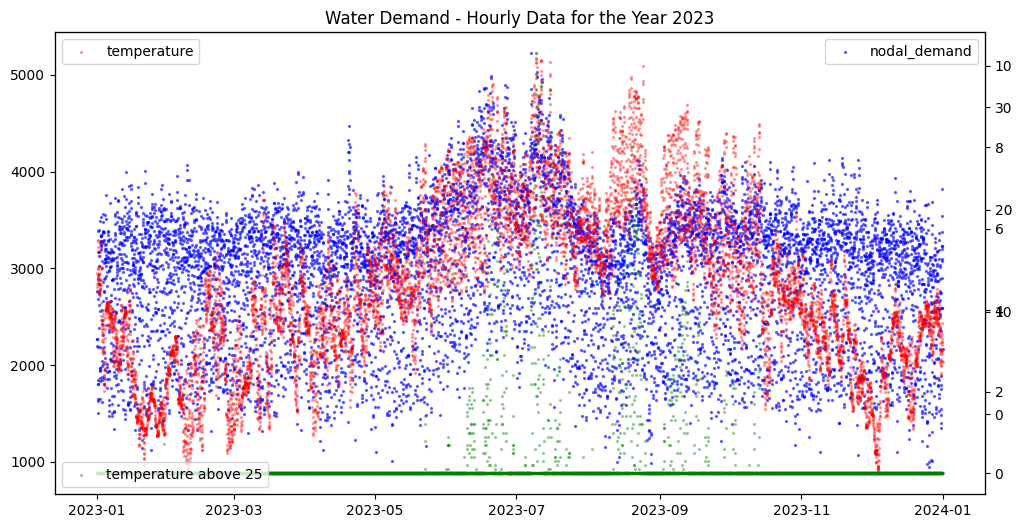

In [42]:
start_date = pd.Timestamp("2023-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="nodal_demand",
    color="blue",
)
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.scatter(
    year_data.index,
    year_data["temperature_Schnar"],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="temperature",
    color="red",
)
ax3 = ax1.twinx()
ax3.scatter(
    year_data.index,
    year_data["T_hot"],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="temperature above 25",
    color="green",
)

# Add legends
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
ax3.legend(loc="lower left")
plt.title(f"Water Demand - Hourly Data for the Year {start_date.year}")
plt.show()

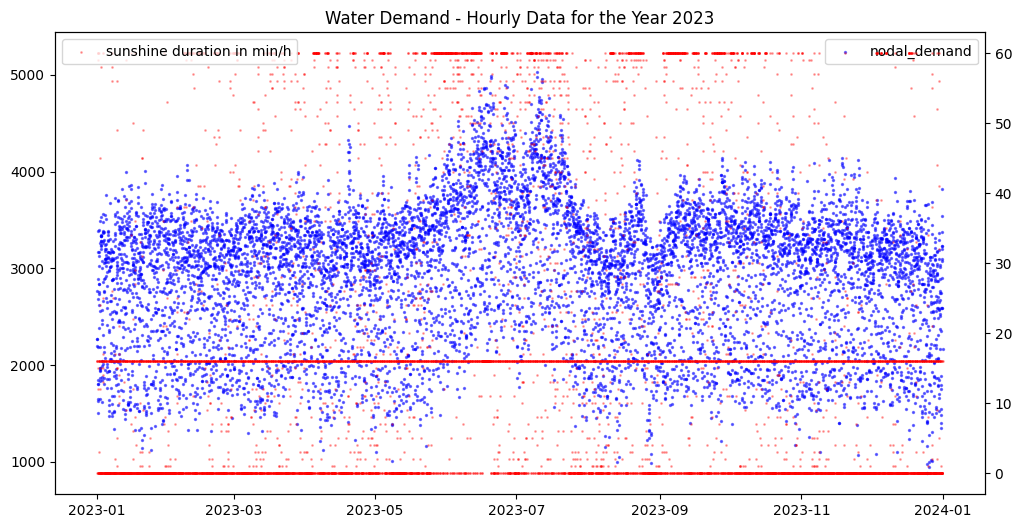

In [45]:
start_date = pd.Timestamp("2023-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="nodal_demand",
    color="blue",
)
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.scatter(
    year_data.index,
    year_data["sunshine_duration_Schnar"],
    s=1,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="sunshine duration in min/h",
    color="red",
)

# Add legends
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.title(f"Water Demand - Hourly Data for the Year {start_date.year}")
plt.show()

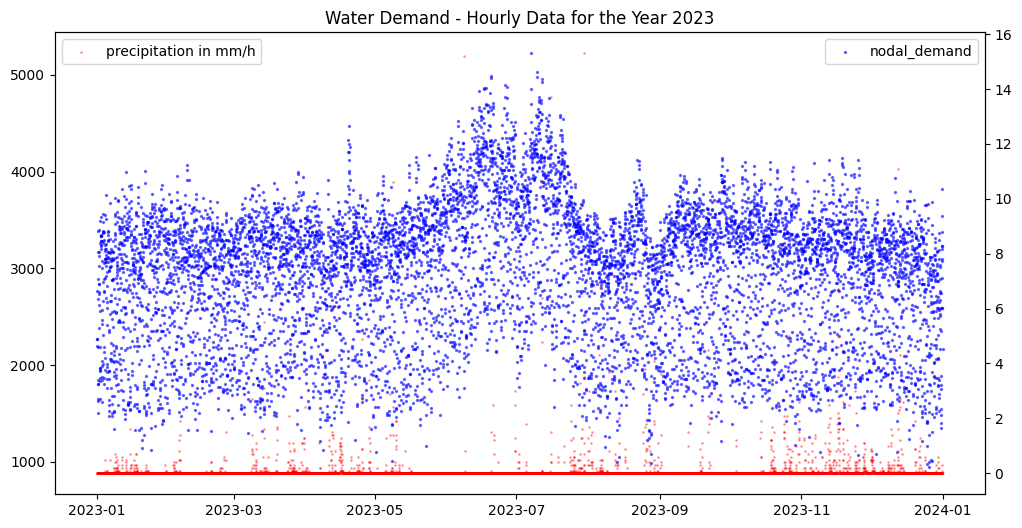

In [46]:
start_date = pd.Timestamp("2023-01-01T00")
end_date = start_date + pd.Timedelta(days=364, hours=23)
year_data = df_merged.loc[start_date:end_date]
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
ax1.scatter(
    year_data.index,
    year_data["nodal_demand"],
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="nodal_demand",
    color="blue",
)
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.scatter(
    year_data.index,
    year_data["precipitation_Schnar"],
    s=1,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="precipitation in mm/h",
    color="red",
)

# Add legends
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.title(f"Water Demand - Hourly Data for the Year {start_date.year}")
plt.show()

#### 2.2.) Weekly basis

In [83]:
start_date = "2023-06-26"
end_date = "2023-07-25"
filtered_df = df_merged[(df_merged.index >= start_date) & (df_merged.index < end_date)]
filtered_df.describe()

,nodal_demand,n_nodal_datapoints_available,TT_TU_Schnar,RF_TU_Schnar,T_hot,T_hot^2,day_of_week,is_weekend
count,696.000000,696.0,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,3555.234382,35.0,21.843103,52.935345,0.731753,4.197744,2.896552,0.275862
std,678.967232,0.0,4.423926,17.095504,1.915085,14.577040,2.041495,0.447269
min,1570.593621,35.0,12.700000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,3085.196001,35.0,18.500000,39.000000,0.000000,0.000000,1.000000,0.000000
50%,3672.562813,35.0,21.200000,51.000000,0.000000,0.000000,3.000000,0.000000
75%,4059.267994,35.0,24.500000,65.000000,0.000000,0.000000,5.000000,1.000000
max,5222.489302,35.0,35.300000,97.000000,10.300000,106.090000,6.000000,1.000000


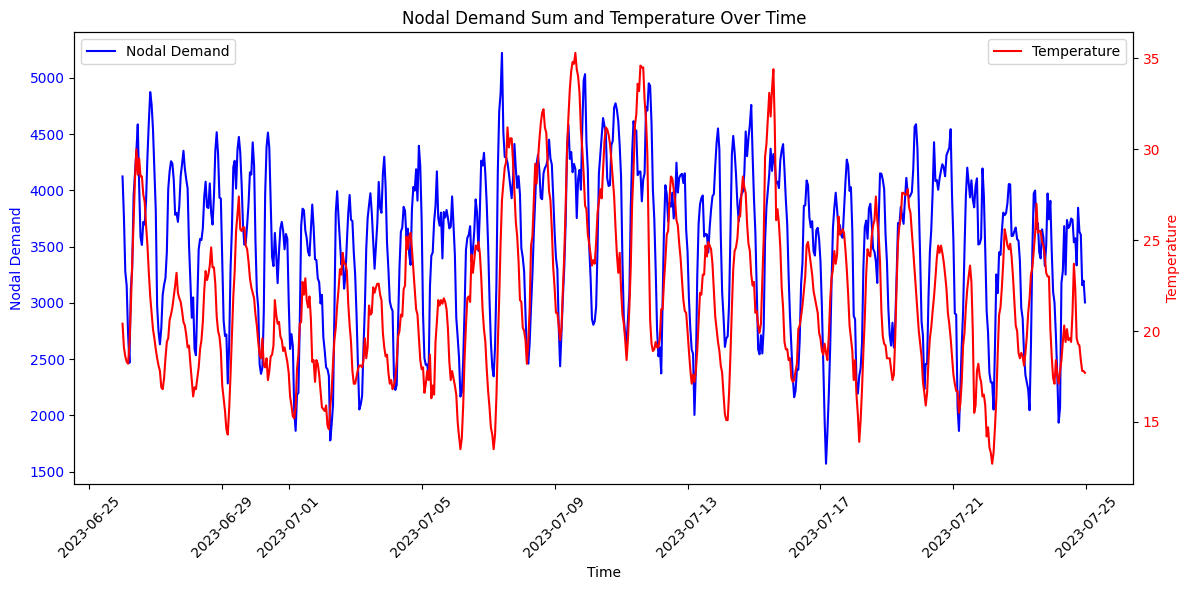

In [147]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the nodal_demand_sum
ax1.plot(
    filtered_df.index,
    filtered_df["nodal_demand"],
    label="Nodal Demand",
    color="b",
)
ax1.set_xlabel("Time")
ax1.set_ylabel("Nodal Demand", color="b")
ax1.tick_params(axis="x", rotation=45)
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df["TT_TU_Schnar"], label="Temperature", color="r")
ax2.set_ylabel("Temperature", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Nodal Demand Sum and Temperature Over Time")
plt.tight_layout()
plt.show()

In [211]:
# Extract the hour and date from the timestamp
year_data["hour"] = year_data.index.hour
year_data["date"] = year_data.index.date


# Separate the data into working days and weekends
working_days = year_data.loc[year_data["is_weekend"] == False].copy()
weekends = year_data.loc[year_data["is_weekend"] == True].copy()
holidays = year_data.loc[year_data["is_holiday"] == True].copy()

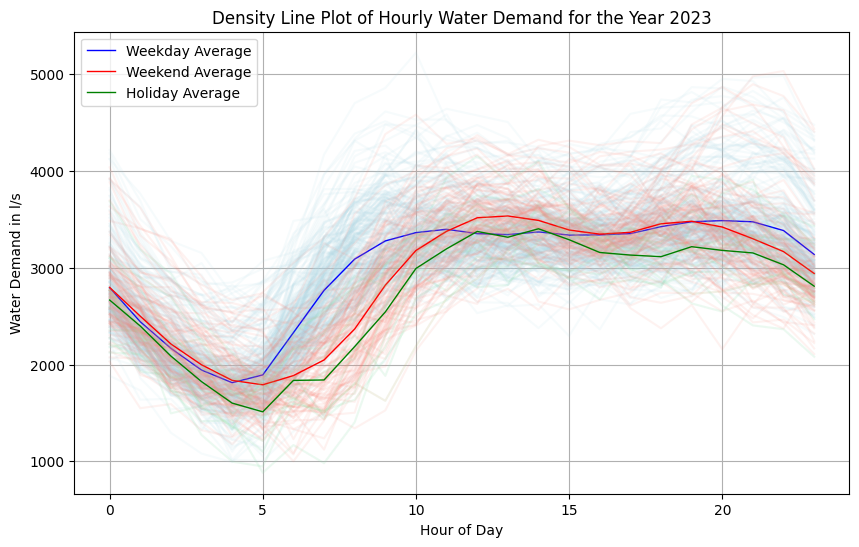

In [212]:
# 3. Pivot to have each day as a row, each hour (0..23) as a column
pivot_wd = (
    working_days.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_we = (
    weekends.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)
pivot_ho = (
    holidays.groupby(["date", "hour"])["nodal_demand"].mean().unstack(level="hour")
)

plt.figure(figsize=(10, 6))

# Plot each weekday's daily line in a faint color
for day in pivot_wd.index:
    plt.plot(pivot_wd.columns, pivot_wd.loc[day], color="lightblue", alpha=0.1)

# Plot the average weekday demand line in thicker blue
avg_wd = pivot_wd.mean(axis=0)
plt.plot(pivot_wd.columns, avg_wd, color="blue", linewidth=1, label="Weekday Average")

# Plot each weekend day's daily line in a faint color
for day in pivot_we.index:
    plt.plot(pivot_we.columns, pivot_we.loc[day], color="salmon", alpha=0.1)

# Plot the average weekend demand line in thicker red
avg_we = pivot_we.mean(axis=0)
plt.plot(pivot_we.columns, avg_we, color="red", linewidth=1, label="Weekend Average")

# Plot each holiday daily line in a faint color
for day in pivot_ho.index:
    plt.plot(pivot_ho.columns, pivot_ho.loc[day], color="lightgreen", alpha=0.1)

# Plot the average holiday demand line in thicker red
avg_ho = pivot_ho.mean(axis=0)
plt.plot(pivot_ho.columns, avg_ho, color="green", linewidth=1, label="Holiday Average")


# Final styling
plt.xlabel("Hour of Day")
plt.ylabel("Water Demand in l/s")
plt.title("Density Line Plot of Hourly Water Demand for the Year 2023")
plt.legend()
plt.grid(True)
plt.show()

### 3.) Build SARIMA model - One day ahead forecast

#### 3.1.) Identifying the dependence orders of the model

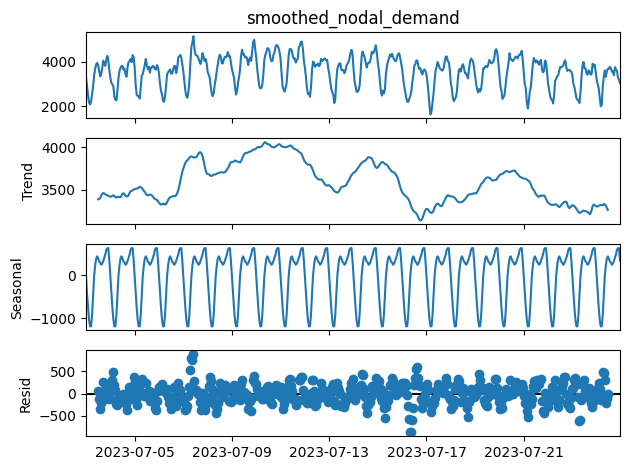

In [14]:
decomposition = seasonal_decompose(
    filtered_df["smoothed_nodal_demand"], model="additive", period=24
)
decomposition.plot()
plt.show()

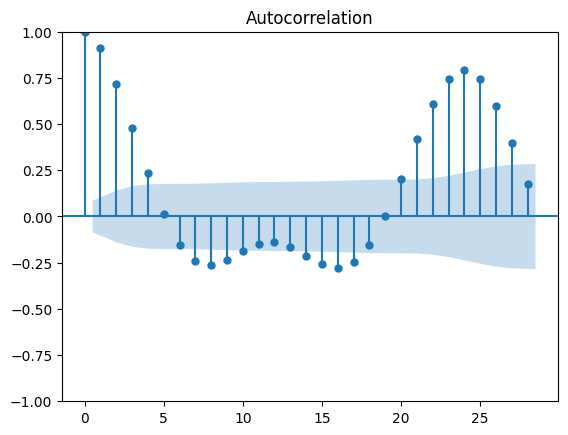

In [15]:
plot_acf(filtered_df["smoothed_nodal_demand"])
plt.show()

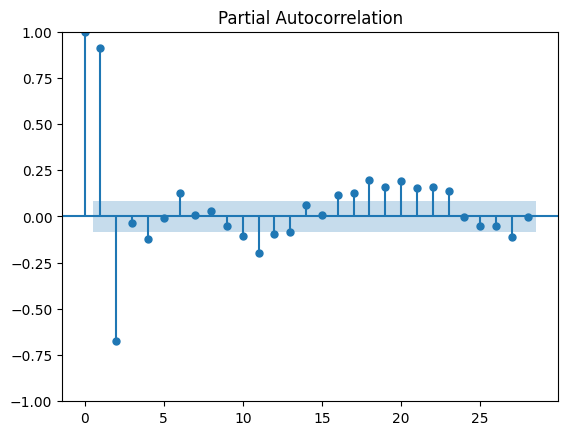

In [16]:
plot_pacf(filtered_df["smoothed_nodal_demand"])
plt.show()

#### 3.2.) Fitting the model

In [17]:
rolling_seven_day_forecast = []
for days in range(0, 7):
    train_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=days)
    train_end_date = train_start_date + pd.Timedelta(days=14) - pd.Timedelta(hours=1)
    fc = train_and_forecast_sarima(filtered_df, train_start_date, train_end_date, 24)
    rolling_seven_day_forecast.append(fc)

order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4500.6
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4501.51
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4488.71
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4474.92
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4478.98
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4468.88
order: (1, 0, 1) x (1, 0, 1, 24) ; BIC: 4480.28


In [ ]:
forecast = np.array(rolling_seven_day_forecast).flatten()
test_start_date = pd.Timestamp(start_date) + pd.Timedelta(days=14)
test_end_date = test_start_date + pd.Timedelta(days=7)
measured = filtered_df.loc[
    (filtered_df.index >= test_start_date) & (filtered_df.index < test_end_date),
    ["smoothed_nodal_demand"],
]
error = measured["smoothed_nodal_demand"] - forecast  # Calculate error

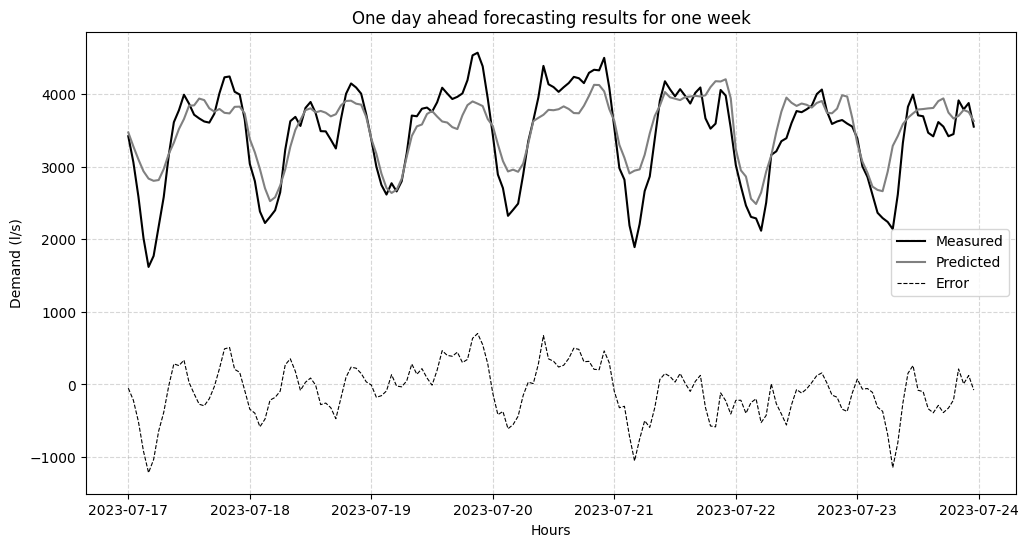

In [24]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot measured and predicted demand
plt.plot(measured.index, measured, label="Measured", color="black", linewidth=1.5)
plt.plot(measured.index, forecast, label="Predicted", color="gray", linewidth=1.5)

# Plot error
plt.plot(
    measured.index, error, label="Error", color="black", linestyle="--", linewidth=0.8
)

# Add labels, legend, and title
plt.xlabel("Hours")
plt.ylabel("Demand (l/s)")
plt.title("One day ahead forecasting results for one week")
plt.legend()

# Add grid
plt.grid(visible=True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

### 4.) SARIMAX - Temperature based
Mid-term forecast based on temperature and time-serie decomposition

In [216]:
start_date = pd.Timestamp("2021-01-01T00")
end_date = pd.Timestamp("2023-12-31T23")
three_year_data = df_merged.loc[start_date:end_date].copy()
three_year_data.describe()

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,TT_TU_Schnar,RF_TU_Schnar,T_hot,T_hot^2,day_of_week,is_weekend
count,26280.000000,26280.000000,26280,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,3021.649505,33.139916,2022-07-02 11:30:00,0.035616,11.670483,70.450647,0.145894,0.683350,3.005479,0.286758
min,882.301577,32.000000,2021-01-01 00:00:00,0.000000,-11.300000,17.000000,0.000000,0.000000,0.000000,0.000000
25%,2538.973624,32.000000,2021-10-01 17:45:00,0.000000,5.500000,58.000000,0.000000,0.000000,1.000000,0.000000
50%,3148.147079,33.000000,2022-07-02 11:30:00,0.000000,11.300000,74.000000,0.000000,0.000000,3.000000,0.000000
75%,3492.109856,33.000000,2023-04-02 05:15:00,0.000000,17.500000,85.000000,0.000000,0.000000,5.000000,1.000000
max,5286.708269,35.000000,2023-12-31 23:00:00,1.000000,36.300000,100.000000,11.300000,127.690000,6.000000,1.000000
std,672.256369,1.101054,NaN,0.185335,7.986673,18.116942,0.813689,5.451111,2.000487,0.452256


In [218]:
# Generate Fourier terms for weekly cycle
K = 3  # Number of sine/cosine pairs (tune as needed)
fourier_df = fourier_series(
    three_year_data.index, K=K, period=168
)  # period = 168 since weekly cycle
three_year_data = three_year_data.join(fourier_df, on="datetime", how="left")
three_year_data.head(5)

,nodal_demand,n_nodal_datapoints_available,date,is_holiday,TT_TU_Schnar,RF_TU_Schnar,T_hot,T_hot^2,day_of_week,is_weekend,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3
datetime,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,2671.679217,32.0,2021-01-01 00:00:00,1,2.5,84.0,0.0,0.0,4,0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2021-01-01 01:00:00,2822.264521,32.0,2021-01-01 01:00:00,1,2.2,87.0,0.0,0.0,4,0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712
2021-01-01 02:00:00,2353.799591,32.0,2021-01-01 02:00:00,1,2.2,87.0,0.0,0.0,4,0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928
2021-01-01 03:00:00,2462.691899,32.0,2021-01-01 03:00:00,1,2.4,87.0,0.0,0.0,4,0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883
2021-01-01 04:00:00,2169.345116,32.0,2021-01-01 04:00:00,1,2.4,87.0,0.0,0.0,4,0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969


In [221]:
#  Prepare the data
endog = three_year_data["nodal_demand"]
exog = three_year_data[
    [
        "T_hot",
        "T_hot^2",
        "is_weekend",
        "is_holiday",
        # "sin_168_1",
        # "cos_168_1",
        # "sin_168_2",
        # "cos_168_2",
        # "sin_168_3",
        # "cos_168_3",
    ]
]

# Split the data into training and testing sets (optional)
train_endog = endog[: 2 * 365 * 24]
test_endog = endog[2 * 365 * 24 + 1 :]
train_exog = exog[: 2 * 365 * 24]
test_exog = exog[2 * 365 * 24 + 1 :]

#### 4.1.) Determine model parameters

In [222]:
# Fit the SARIMAX model
model = SARIMAX(
    train_endog, exog=train_exog, order=(1, 0, 3), seasonal_order=(0, 1, 1, 24)
)
results = model.fit()
# Print the summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         nodal_demand   No. Observations:                17520
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 24)   Log Likelihood             -117416.462
Date:                              Fri, 31 Jan 2025   AIC                         234852.924
Time:                                      20:21:48   BIC                         234930.622
Sample:                                  01-01-2021   HQIC                        234878.510
                                       - 12-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T_hot         36.0487      9.882      3.648      0.000      16.680      55.418
T_hot^2       -3.95

In [223]:
# Make predictions one year ahead
predictions = results.get_forecast(steps=364 * 24 + 23, exog=test_exog)
predicted_mean = predictions.predicted_mean

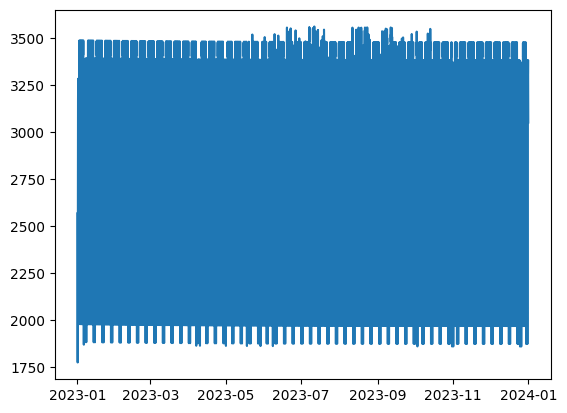

In [224]:
plt.plot(predicted_mean.index[0 : 364 * 24 + 23], predicted_mean[0 : 364 * 24 + 23])

In [43]:
len(test_endog.index)

8759

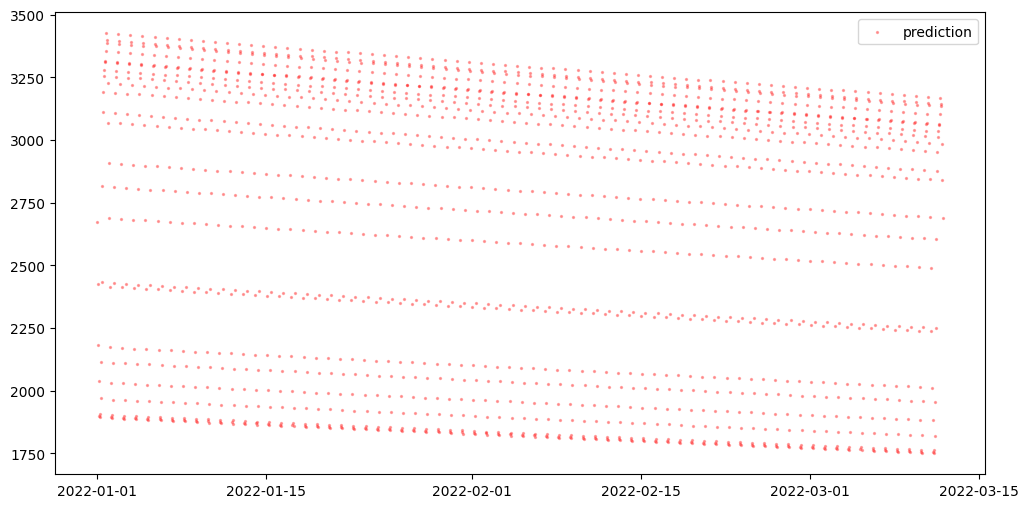

In [61]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.scatter(
    predicted_mean.index[0 : 24 * 7 * 10],
    predicted_mean[0 : 24 * 7 * 10],
    s=2,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="prediction",
    color="red",
)
# Add legends
ax1.legend(loc="upper right")
# ax2.legend(loc="upper left")
# plt.title(f"water demand hourly data for the year {start_date.year}")
plt.show()

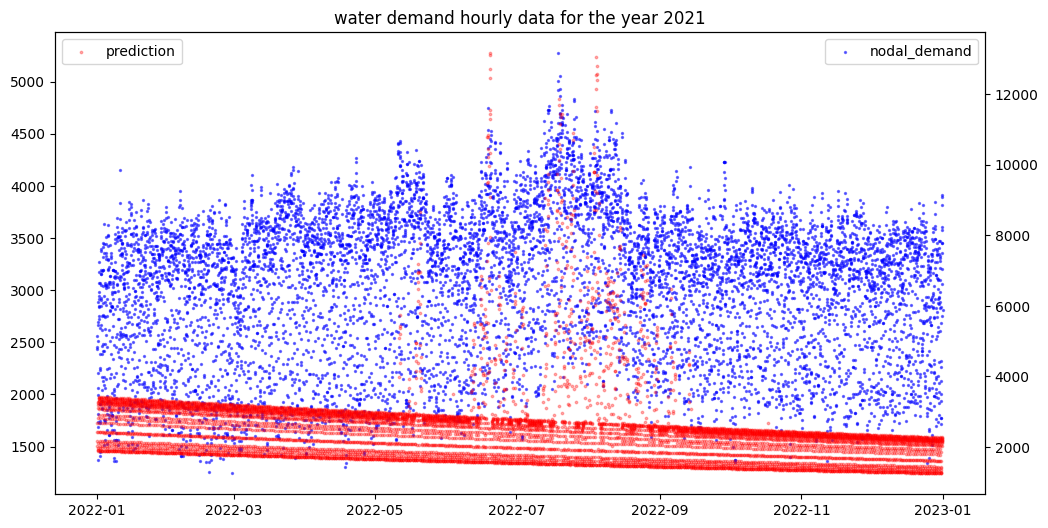

In [63]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a label for the year
label = f"{start_date.year}"
ax1.scatter(
    test_endog.index,
    test_endog,
    s=2,  # Size of dots
    alpha=0.5,  # Transparency of dots
    label="nodal_demand",
    color="blue",
)
# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.scatter(
    predicted_mean.index,
    predicted_mean,
    s=3,  # Size of dots
    alpha=0.3,  # Transparency of dots
    label="prediction",
    color="red",
)
# Add legends
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.title(f"water demand hourly data for the year {start_date.year}")
plt.show()

### 5.) Prophet